# Bank Marketing Prediction System
## 1. Problem Selection & Definition
### 1.1 The Problem
The problem is to predict whether a client will subscribe to a term deposit (the target variable 'deposit') based on demographic data and previous marketing interactions.
### 1.2 Importance
For banks, term deposits are a major source of income. Predicting which customers are likely to subscribe allows for optimized marketing strategies, reduced operational costs, and higher customer conversion rates by targeting the right individuals.
### 1.3 Machine Learning Role
Machine Learning can analyze complex patterns in historical customer data (age, balance, contact history) that are difficult for humans to process manually. By training classification models, the bank can automate the lead-scoring process with high accuracy.

In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report , ConfusionMatrixDisplay
# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE



## 1. Load dataset

Load the Bank Marketing Dataset (CSV).

Display the first few rows to understand the data.

Identify the target column (deposit) and input features.


In [41]:
# 1.1 Load dataset
df = pd.read_csv("bank.csv")
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 2. Exploratory Data Analysis (EDA) & Feature Understanding

  """
### Dataset Overview
Check the dataset shape (rows and columns).

Display dataset info (data types, non-null counts).

Describe basic statistics for numeric and categorical features.
"""
  


In [42]:
# Number of rows and columns
print(f"Dataset Dimensions: {df.shape[0]} rows and {df.shape[1]} columns")

# Summary statistics for all features
print("\n--- Summary Statistics ---")
display(df.describe(include='all'))

# Feature Definitions
# Requirement 4.i: Briefly describe what each feature represents
descriptions = {
    'age': 'Age of the client',
    'job': 'Type of job (e.g., admin, blue-collar)',
    'marital': 'Marital status (married, single, divorced)',
    'education': 'Education level (primary, secondary, tertiary)',
    'default': 'Has credit in default?',
    'balance': 'Average yearly balance in euros',
    'housing': 'Has housing loan?',
    'loan': 'Has personal loan?',
    'contact': 'Contact communication type',
    'day': 'Last contact day of the month',
    'month': 'Last contact month of year',
    'duration': 'Last contact duration in seconds',
    'campaign': 'Number of contacts during this campaign',
    'pdays': 'Days since last contact (-1 means never)',
    'previous': 'Number of contacts before this campaign',
    'poutcome': 'Outcome of previous marketing campaign',
    'deposit': 'Target: Did the client subscribe?'
}

Dataset Dimensions: 11162 rows and 17 columns

--- Summary Statistics ---


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
count,11162.000000,11162,11162,11162,11162,11162.000000,11162,11162,11162,11162.000000,11162,11162.000000,11162.000000,11162.000000,11162.000000,11162,11162
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,no,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,2566,6351,5476,10994,NaN,5881,9702,8042,NaN,2824,NaN,NaN,NaN,NaN,8326,5873
mean,41.231948,NaN,NaN,NaN,NaN,1528.538524,NaN,NaN,NaN,15.658036,NaN,371.993818,2.508421,51.330407,0.832557,NaN,NaN
std,11.913369,NaN,NaN,NaN,NaN,3225.413326,NaN,NaN,NaN,8.420740,NaN,347.128386,2.722077,108.758282,2.292007,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-6847.000000,NaN,NaN,NaN,1.000000,NaN,2.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,NaN,NaN,122.000000,NaN,NaN,NaN,8.000000,NaN,138.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,550.000000,NaN,NaN,NaN,15.000000,NaN,255.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1708.000000,NaN,NaN,NaN,22.000000,NaN,496.000000,3.000000,20.750000,1.000000,NaN,NaN


### Justification of Feature Types:
*   **Numerical**: Features like `age` and `balance` are quantitative and represent continuous physical quantities.
*   **Binary**: Features like `housing` and `loan` have only two distinct states (Yes/No).
*   **Ordinal**: `education` is ordinal because it has a hierarchy (e.g., Tertiary is higher than Primary).
*   **Nominal**: `job` and `marital` are nominal as they represent categories with no mathematical order between them.

In [43]:
# Feature Type Identification & Justification
# Numerical: Continuous or discrete measurements
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Binary: Only two possible categories (yes/no)
binary_features = ['default', 'housing', 'loan']

# Ordinal: Categories with a natural order/rank
ordinal_features = ['education'] # (primary < secondary < tertiary)

# Nominal: Categories without inherent ranking
nominal_features = ['job', 'marital', 'contact', 'month', 'poutcome']

print("--- Feature Classification ---")
print(f"Numerical ({len(numerical_features)}): {numerical_features}")
print(f"Binary ({len(binary_features)}): {binary_features}")
print(f"Ordinal ({len(ordinal_features)}): {ordinal_features}")
print(f"Nominal ({len(nominal_features)}): {nominal_features}")

--- Feature Classification ---
Numerical (7): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Binary (3): ['default', 'housing', 'loan']
Ordinal (1): ['education']
Nominal (5): ['job', 'marital', 'contact', 'month', 'poutcome']


"""
### Missing Values Analysis
Check for missing values and decide imputation method.

"""


In [44]:
# Missing Value Analysis
missing_count = df.isnull().sum()
missing_pct = (missing_count / len(df)) * 100
missing_report = pd.DataFrame({'Count': missing_count, 'Percentage (%)': missing_pct})

print("--- Missing Values Report ---")
display(missing_report[missing_report['Count'] > 0] if missing_count.sum() > 0 else "No missing values found.")

--- Missing Values Report ---


'No missing values found.'

### Feature Distribution
Visualize numerical features with histograms and categorical features with bar charts.
"""


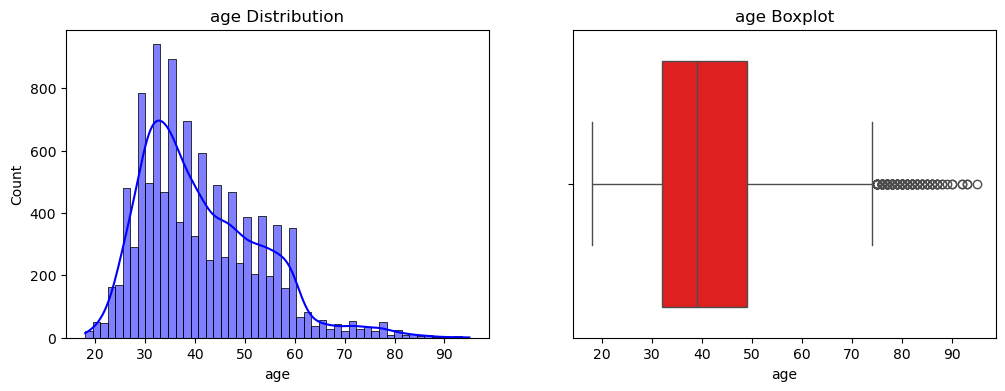

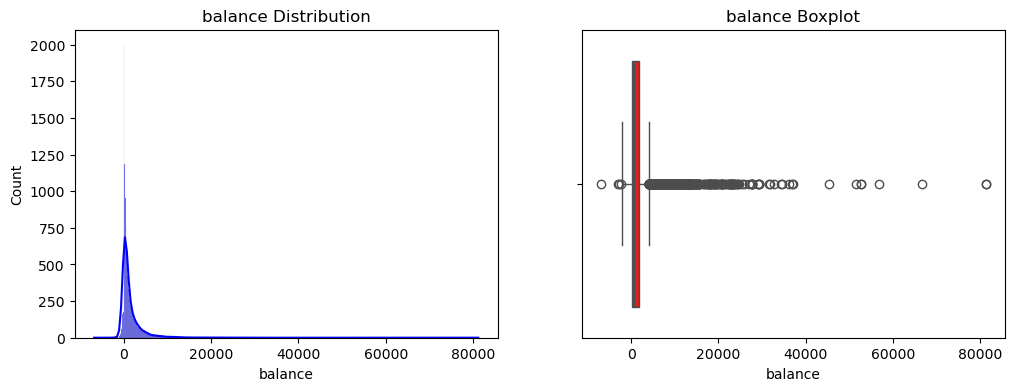

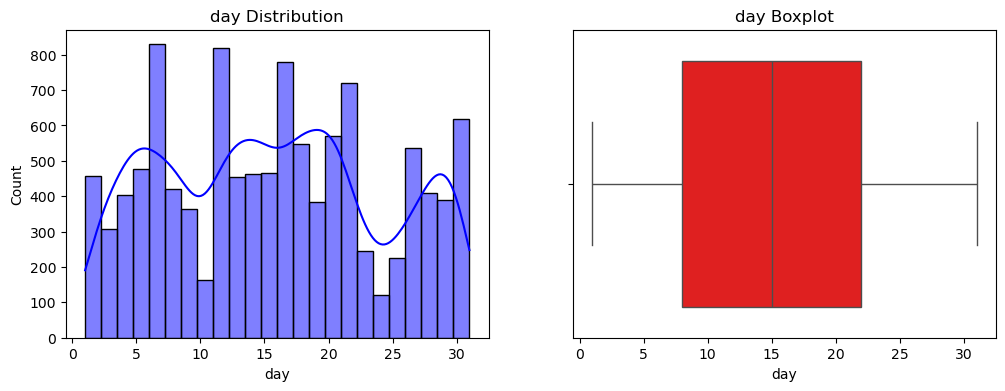

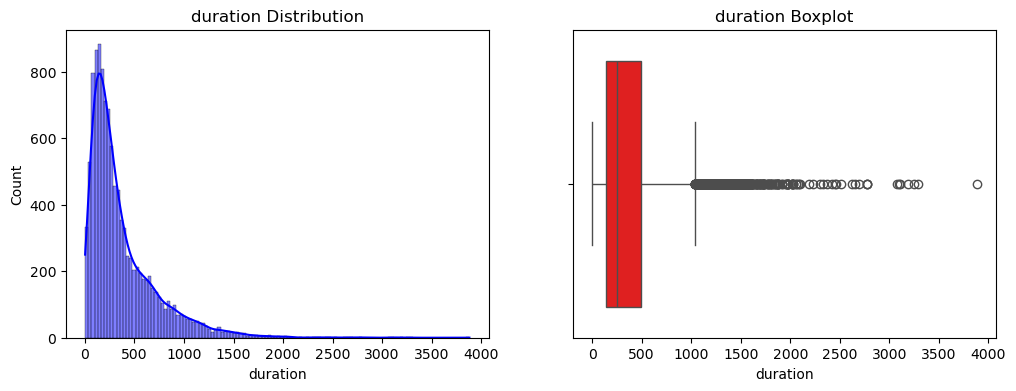

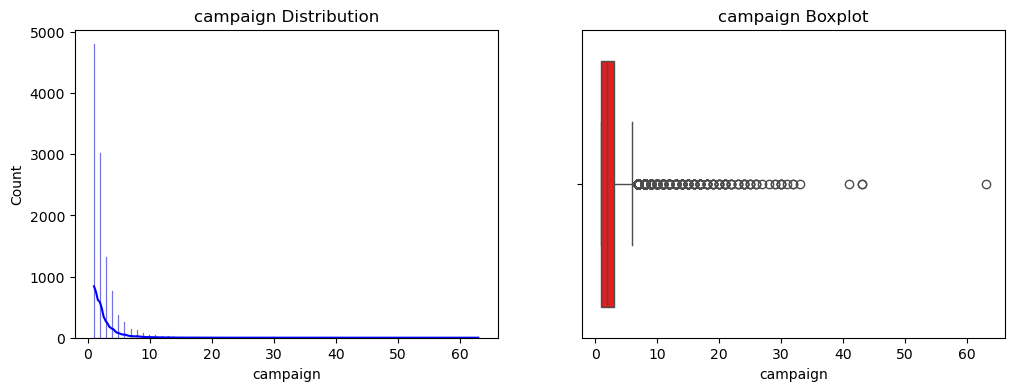

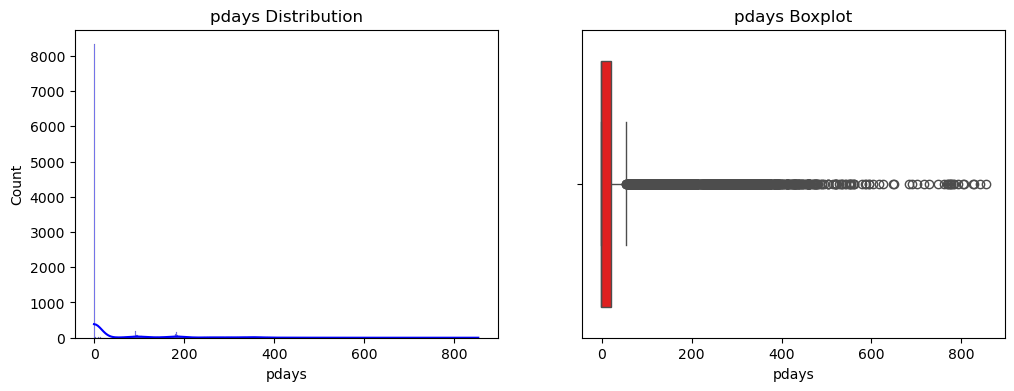

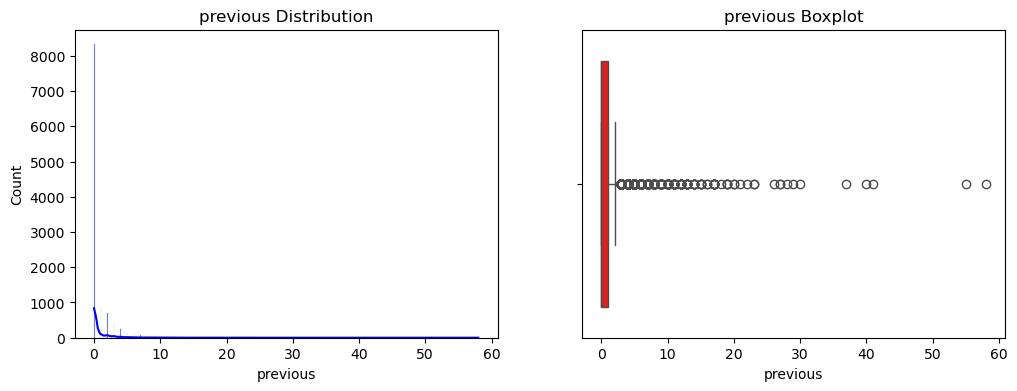

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


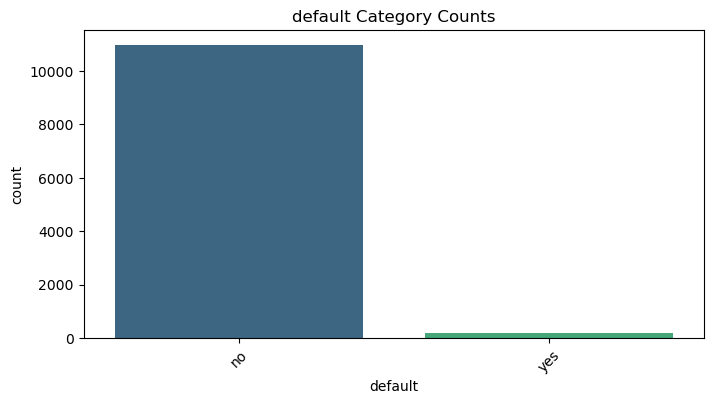

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


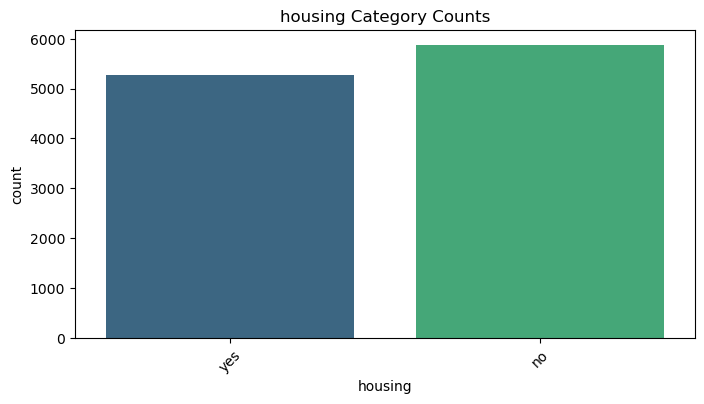

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


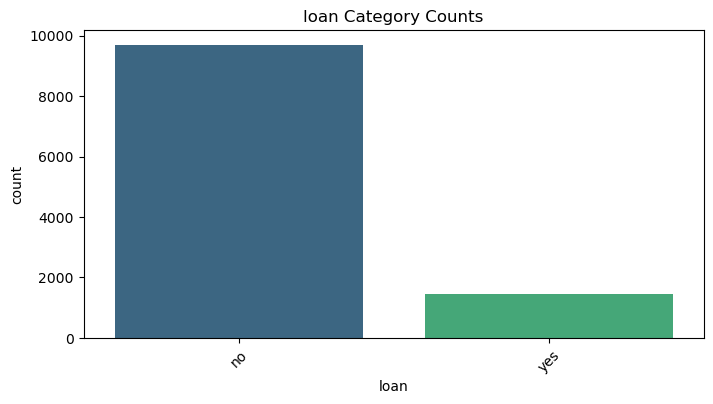

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


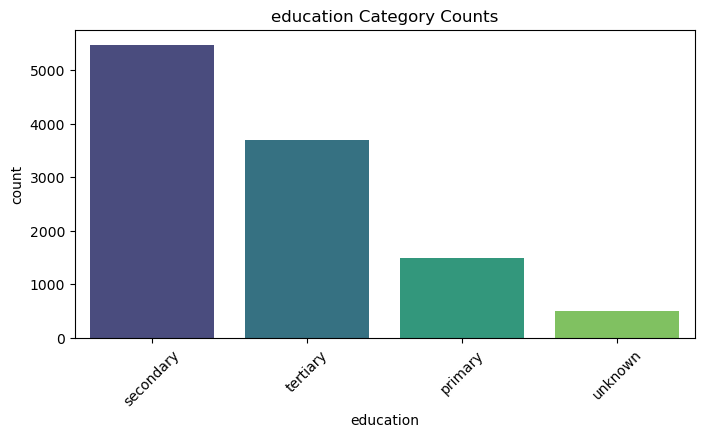

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


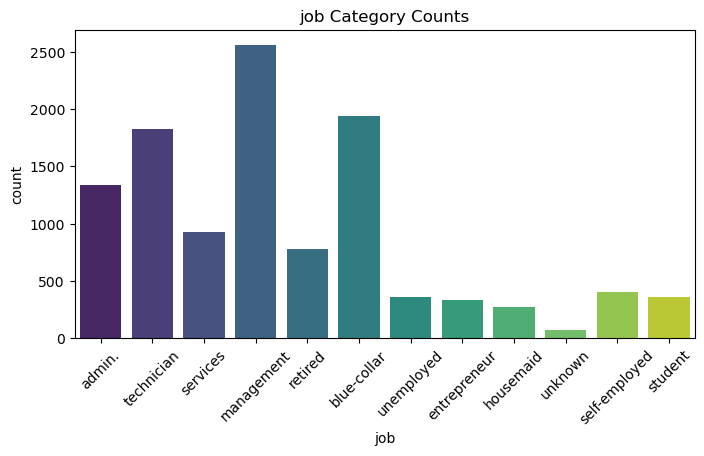

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


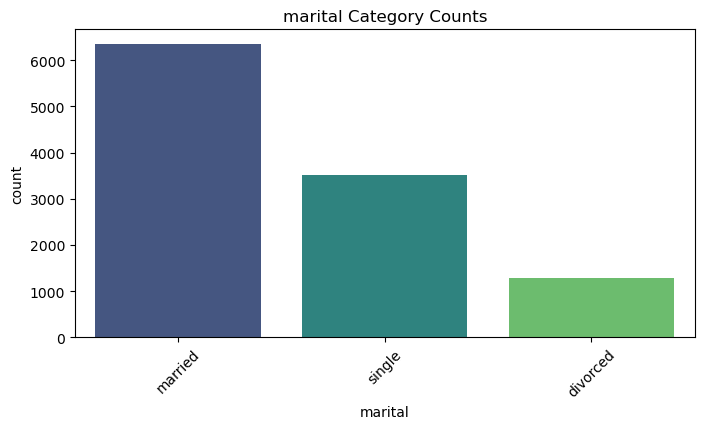

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


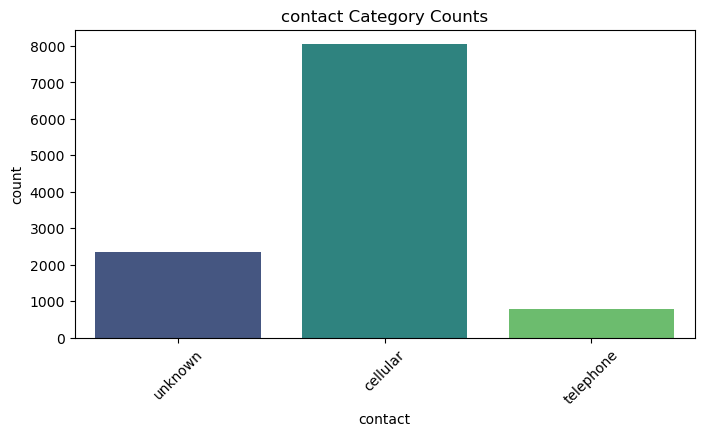

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


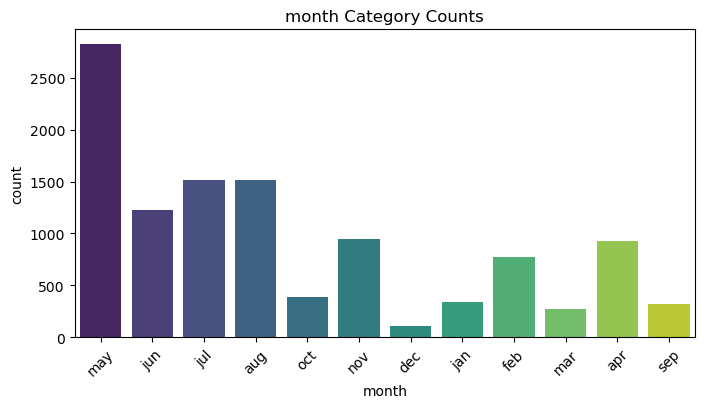

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\2642190863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


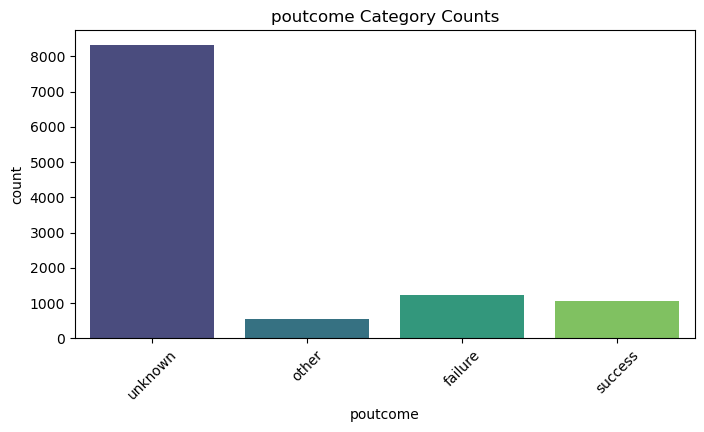

In [45]:
# Requirement 4.iv: Feature Distribution with analysis
for col in numerical_features:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'{col} Distribution')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col], color='red')
    plt.title(f'{col} Boxplot')
    plt.show()

# Categorical features
for col in binary_features + ordinal_features + nominal_features:
    plt.figure(figsize=(8,4))
    sns.countplot(x=df[col], palette='viridis')
    plt.title(f'{col} Category Counts')
    plt.xticks(rotation=45)
    plt.show()

"""

### Feature Relationships
- Correlation heatmap for numerical features
- Feature vs target correlation
"""

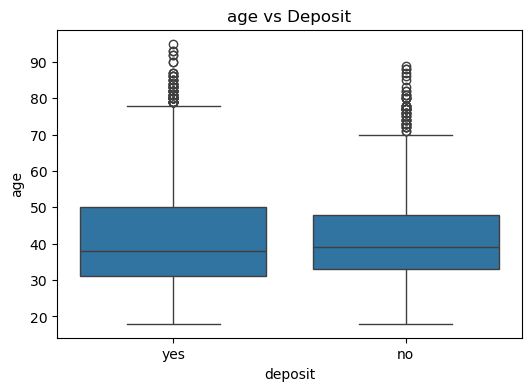

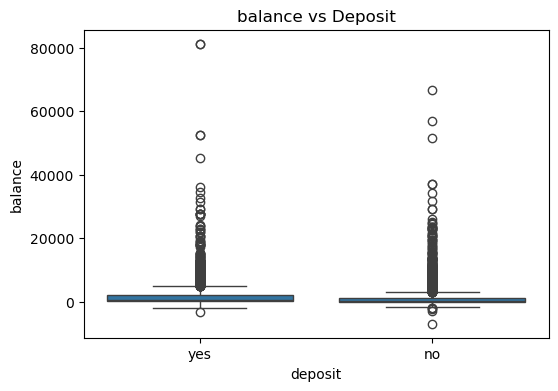

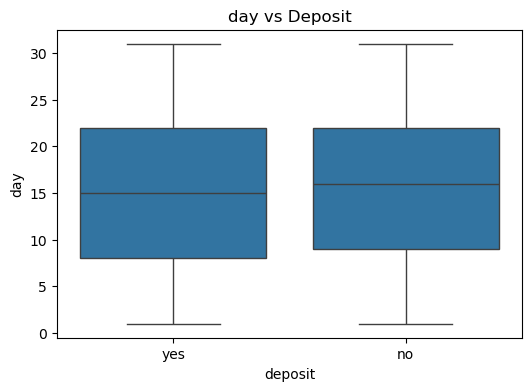

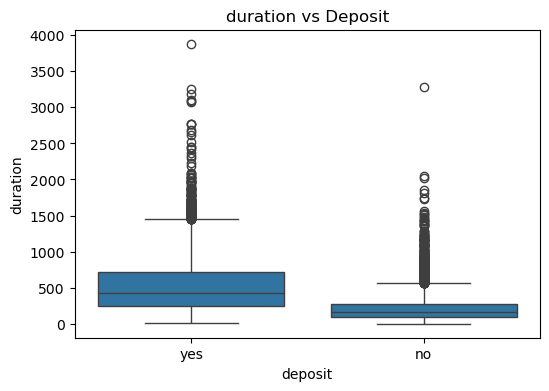

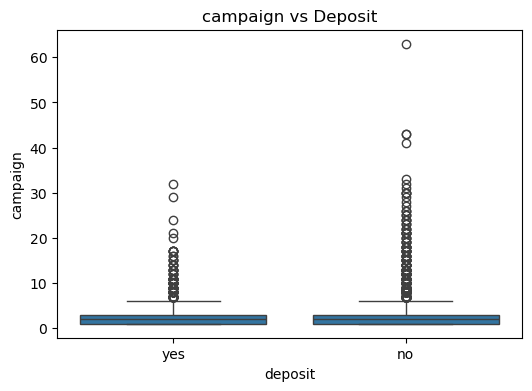

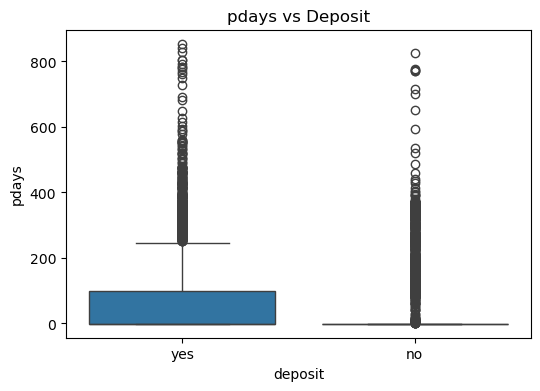

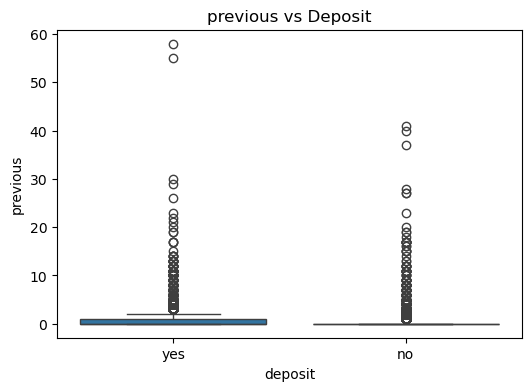

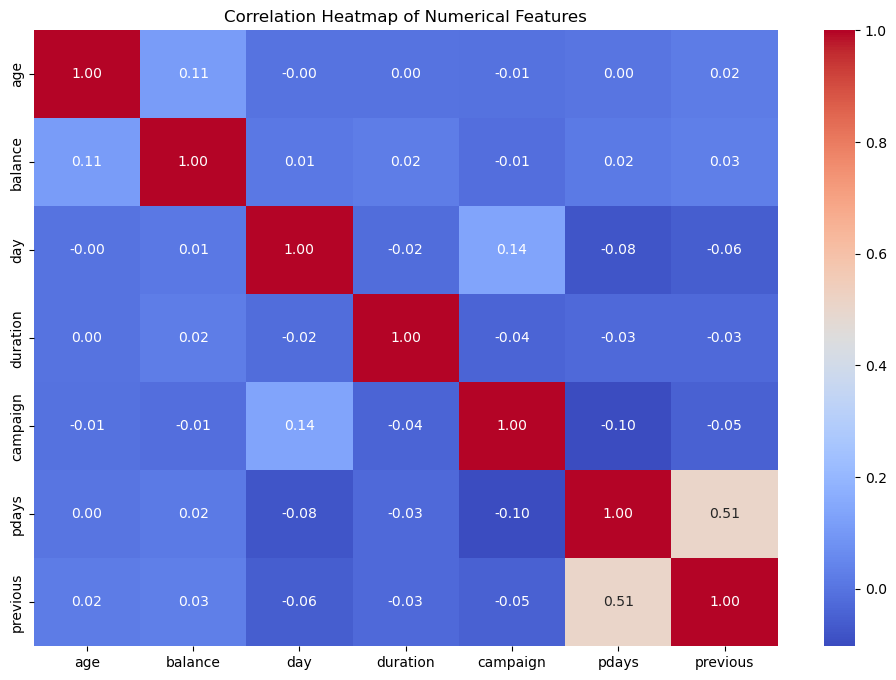

In [46]:
# Requirement 4.v: Feature Relationships
# Numerical vs Target
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='deposit', y=col, data=df)
    plt.title(f'{col} vs Deposit')
    plt.show()

# Requirement 4.v: Correlation Heatmap (encoding temporarily to show correlations)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Class Distribution
Visualize the target variable distribution and check for balance.
"""

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\1019751852.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['deposit'], palette='magma')


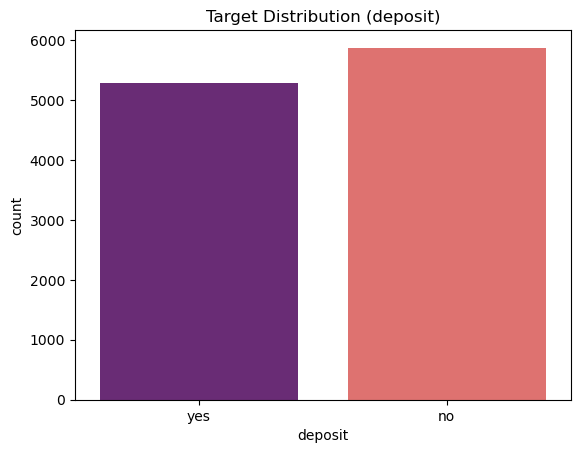

Class Counts:
 deposit
no     5873
yes    5289
Name: count, dtype: int64

Class Percentages:
 deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64


In [47]:
# Requirement 4.vi & 5.2: Class Distribution 
sns.countplot(x=df['deposit'], palette='magma')
plt.title("Target Distribution (deposit)")
plt.show()

print("Class Counts:\n", df['deposit'].value_counts())
print("\nClass Percentages:\n", df['deposit'].value_counts(normalize=True))

"""
### Data Preprocessing

- Encode categorical features
- Handle class imbalance using SMOTE
- Scale numerical features
- 
"""

In [48]:
#missing value
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
print(pd.concat([missing_values, missing_percentage], axis=1, keys=['Count', 'Percentage']))

           Count  Percentage
age            0         0.0
job            0         0.0
marital        0         0.0
education      0         0.0
default        0         0.0
balance        0         0.0
housing        0         0.0
loan           0         0.0
contact        0         0.0
day            0         0.0
month          0         0.0
duration       0         0.0
campaign       0         0.0
pdays          0         0.0
previous       0         0.0
poutcome       0         0.0
deposit        0         0.0


In [49]:
col=df.columns
col

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [50]:
# Requirement 5.3: Encoding Categorical Features
df_cleaned = df.copy()

# 1. Binary Categorical (Label Encoding / Simple Mapping)
for col in binary_features:
    df_cleaned[col] = df_cleaned[col].map({'yes': 1, 'no': 0})

# 2. Ordinal Categorical (Manual mapping to preserve order)
edu_mapping = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
df_cleaned['education'] = df_cleaned['education'].map(edu_mapping)

# 3. Nominal Categorical (One-Hot Encoding)
df_cleaned = pd.get_dummies(df_cleaned, columns=nominal_features, drop_first=True)

# 4. Target Variable
df_cleaned['deposit'] = df_cleaned['deposit'].map({'yes': 1, 'no': 0})

print("Encoding Complete. New Shape:", df_cleaned.shape)

Encoding Complete. New Shape: (11162, 41)


### Dataset Splitting
Split data into training and testing sets.
"""

In [51]:
# Requirement 5.5: Dataset Splitting (Train, Val, Test)
X = df_cleaned.drop('deposit', axis=1)
y = df_cleaned['deposit']

# Split 1: Separate Test set (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split 2: Separate Validation set (20% of the remaining 80%, which is ~15% of total)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Requirement 5.4: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (7143, 40)
Validation set: (1786, 40)
Testing set: (2233, 40)


SMOTE

In [52]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

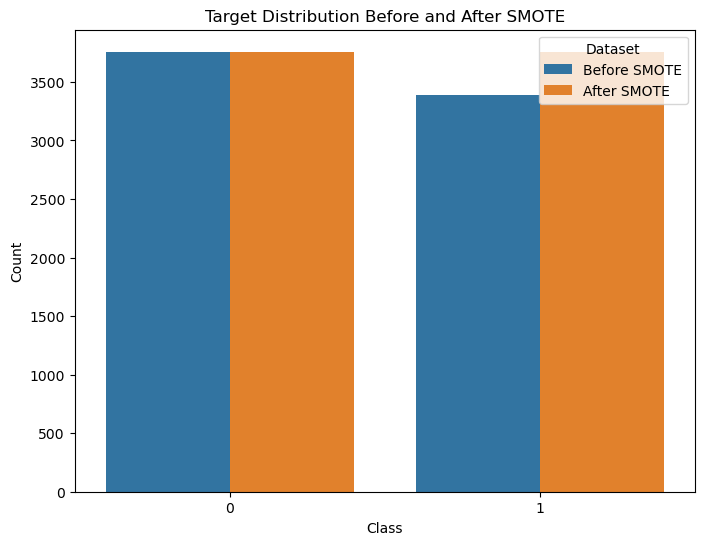

In [53]:
# Before SMOTE
before_counts = pd.Series(y_train).value_counts()
# After SMOTE
after_counts = pd.Series(y_train_res).value_counts()

# Create a DataFrame
df_counts = pd.DataFrame({
    'Class': before_counts.index,
    'Before SMOTE': before_counts.values,
    'After SMOTE': after_counts.values
})

# Melting
df_counts = df_counts.melt(id_vars='Class', 
                           var_name='Dataset', 
                           value_name='Count')

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_counts)
plt.title('Target Distribution Before and After SMOTE')
plt.show()

## 6. Model Building 
Build the following classification models:

Logistic Regression

K-Nearest Neighbors (KNN)

Naive Bayes

Decision Tree

Random Forest

Train each model and evaluate initial performance before tuning.

"""
### Model Building: K-Nearest Neighbors (KNN)
"""

In [54]:
#KNN

knn = KNeighborsClassifier()
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test)

print("KNN Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1-Score:", f1_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

KNN Results:
Accuracy: 0.780564263322884
Precision: 0.7857142857142857
Recall: 0.7381852551984878
F1-Score: 0.7612085769980507
Confusion Matrix:
 [[962 213]
 [277 781]]


"""
### Model Building: Naive Bayes
"""

In [55]:
#naive bayes


nb = GaussianNB()
nb.fit(X_train_res, y_train_res)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1-Score:", f1_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Naive Bayes Results:
Accuracy: 0.7138378862516793
Precision: 0.7988587731811697
Recall: 0.5293005671077504
F1-Score: 0.6367254121660034
Confusion Matrix:
 [[1034  141]
 [ 498  560]]


"""
### Model Building: Logistic Regression
"""

In [56]:
#logistic regression


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Results:
Accuracy: 0.8298253470667264
Precision: 0.8210227272727273
Recall: 0.8194706994328923
F1-Score: 0.8202459791863765
Confusion Matrix:
 [[986 189]
 [191 867]]


"""
### Model Building: Decision Tree
"""

In [57]:
#descion tree


dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1-Score:", f1_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Decision Tree Results:
Accuracy: 0.7922077922077922
Precision: 0.7866795366795367
Recall: 0.7703213610586012
F1-Score: 0.778414517669532
Confusion Matrix:
 [[954 221]
 [243 815]]


"""
### Model Building: Random Forest
"""

In [58]:
#random forest

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.8571428571428571
Precision: 0.8215839860748477
Recall: 0.8922495274102079
F1-Score: 0.8554599003171727
Confusion Matrix:
 [[970 205]
 [114 944]]


"""
### Hyperparameter Tuning
Use GridSearchCV to find the best hyperparameters.

Select important hyperparameters controlling complexity and bias-variance tradeoff.

Compare model performance before and after tuning.

"""

In [59]:
#for KNN


knn_params = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train_res, y_train_res)

print("Best KNN Params:", knn_grid.best_params_)

y_pred_knn_tuned = knn_grid.predict(X_test)

print("KNN Tuned Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn_tuned))
print("Precision:", precision_score(y_test, y_pred_knn_tuned))
print("Recall:", recall_score(y_test, y_pred_knn_tuned))
print("F1-Score:", f1_score(y_test, y_pred_knn_tuned))


Best KNN Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
KNN Tuned Results:
Accuracy: 0.7854903716972682
Precision: 0.8018769551616267
Recall: 0.7268431001890359
F1-Score: 0.7625185919682697


In [60]:
nb_params = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
}

nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='f1', n_jobs=-1)
nb_grid.fit(X_train_res, y_train_res)

print("Best Naive Bayes Params:", nb_grid.best_params_)

y_pred_nb_tuned = nb_grid.predict(X_test)

print("Naive Bayes Tuned Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_tuned))
print("Precision:", precision_score(y_test, y_pred_nb_tuned))
print("Recall:", recall_score(y_test, y_pred_nb_tuned))
print("F1-Score:", f1_score(y_test, y_pred_nb_tuned))


Best Naive Bayes Params: {'var_smoothing': 1e-09}
Naive Bayes Tuned Results:
Accuracy: 0.7138378862516793
Precision: 0.7988587731811697
Recall: 0.5293005671077504
F1-Score: 0.6367254121660034


In [61]:
lr_params = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"]
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train_res, y_train_res)

print("Best Logistic Regression Params:", lr_grid.best_params_)

y_pred_lr_tuned = lr_grid.predict(X_test)

print("Logistic Regression Tuned Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_tuned))
print("Precision:", precision_score(y_test, y_pred_lr_tuned))
print("Recall:", recall_score(y_test, y_pred_lr_tuned))
print("F1-Score:", f1_score(y_test, y_pred_lr_tuned))


Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Tuned Results:
Accuracy: 0.8298253470667264
Precision: 0.8210227272727273
Recall: 0.8194706994328923
F1-Score: 0.8202459791863765


In [62]:
dt_params = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train_res, y_train_res)

print("Best Decision Tree Params:", dt_grid.best_params_)

y_pred_dt_tuned = dt_grid.predict(X_test)

print("Decision Tree Tuned Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_tuned))
print("Precision:", precision_score(y_test, y_pred_dt_tuned))
print("Recall:", recall_score(y_test, y_pred_dt_tuned))
print("F1-Score:", f1_score(y_test, y_pred_dt_tuned))


Best Decision Tree Params: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree Tuned Results:
Accuracy: 0.8145991939095387
Precision: 0.8096153846153846
Recall: 0.7958412098298677
F1-Score: 0.8026692087702574


In [63]:
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res)

print("Best Random Forest Params:", rf_grid.best_params_)

y_pred_rf_tuned = rf_grid.predict(X_test)

print("Random Forest Tuned Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("Precision:", precision_score(y_test, y_pred_rf_tuned))
print("Recall:", recall_score(y_test, y_pred_rf_tuned))
print("F1-Score:", f1_score(y_test, y_pred_rf_tuned))



Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Tuned Results:
Accuracy: 0.8571428571428571
Precision: 0.8215839860748477
Recall: 0.8922495274102079
F1-Score: 0.8554599003171727


"""
### Model Comparison
Compare all models using F1-score or accuracy in a chart.
"""

In [64]:
from tqdm import tqdm

In [65]:
models={
    'LogisticRegression':LogisticRegression(),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(n_estimators= 30, criterion = 'log_loss',max_depth=10),
    "KNeighborsClassifier":KNeighborsClassifier(),
    "naive_bayes":GaussianNB(),

}

In [66]:
models_loss={}
for model_name , model in tqdm(models.items()):
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    models_loss[model_name]=[
        accuracy_score(y_train,y_pred_train),
        accuracy_score(y_test,y_pred_test),
        precision_score(y_train,y_pred_train,average="micro"),
        precision_score(y_test,y_pred_test,average="micro"),
        
        recall_score(y_train,y_pred_train,average="micro"),
        recall_score(y_test,y_pred_test,average="micro"),
        f1_score(y_train,y_pred_train,average="micro"),
        f1_score(y_test,y_pred_test,average="micro"), 
    
    ]

100%|██████████| 5/5 [00:00<00:00,  7.55it/s]


In [67]:
d=pd.DataFrame(models_loss).T

In [68]:
d.columns = ['accuracy_score_train', 'accuracy_score_test', 'precision_score_train',"precision_score_test"
             ,"recall_score_train","recall_score_test","f1_score_train","f1_score_test"]

In [69]:
d

,accuracy_score_train,accuracy_score_test,precision_score_train,precision_score_test,recall_score_train,recall_score_test,f1_score_train,f1_score_test
LogisticRegression,0.826123,0.826243,0.826123,0.826243,0.826123,0.826243,0.826123,0.826243
DecisionTreeClassifier,1.000000,0.799821,1.000000,0.799821,1.000000,0.799821,1.000000,0.799821
RandomForestClassifier,0.882962,0.846843,0.882962,0.846843,0.882962,0.846843,0.882962,0.846843
KNeighborsClassifier,0.842363,0.777429,0.842363,0.777429,0.842363,0.777429,0.842363,0.777429
naive_bayes,0.713286,0.712047,0.713286,0.712047,0.713286,0.712047,0.713286,0.712047


In [70]:
results_df = pd.DataFrame.from_dict(
    models_loss,
    orient='index',
    columns=[
        'Train Accuracy', 'Test Accuracy',
        'Train Precision', 'Test Precision',
        'Train Recall', 'Test Recall',
        'Train F1', 'Test F1'
    ]
).reset_index().rename(columns={'index': 'Model'})

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\1460952456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test Accuracy', data=results_df, palette='viridis')


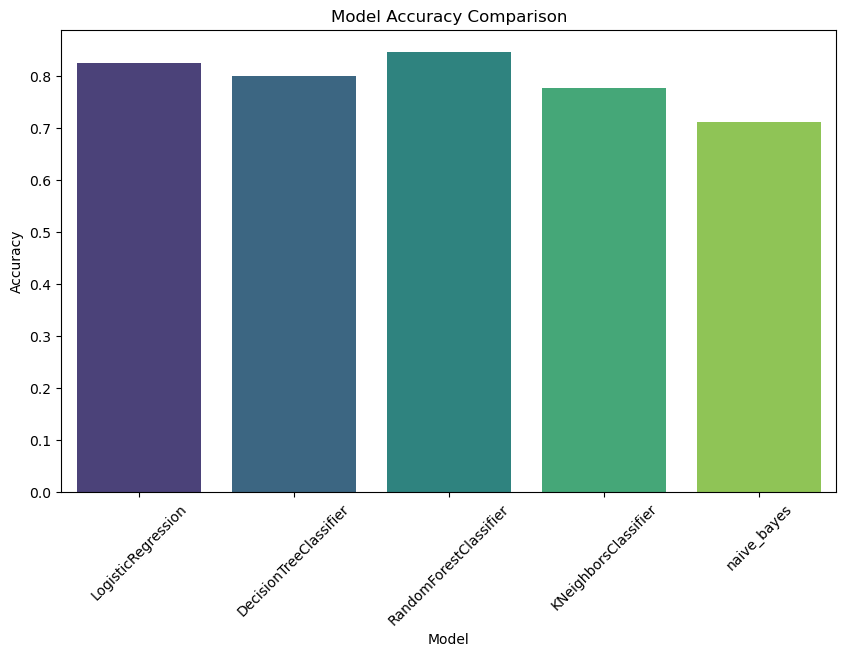

In [71]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Test Accuracy', data=results_df, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

C:\Users\Mohamed\AppData\Local\Temp\ipykernel_18748\1554764871.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test F1', data=results_df, palette='viridis')


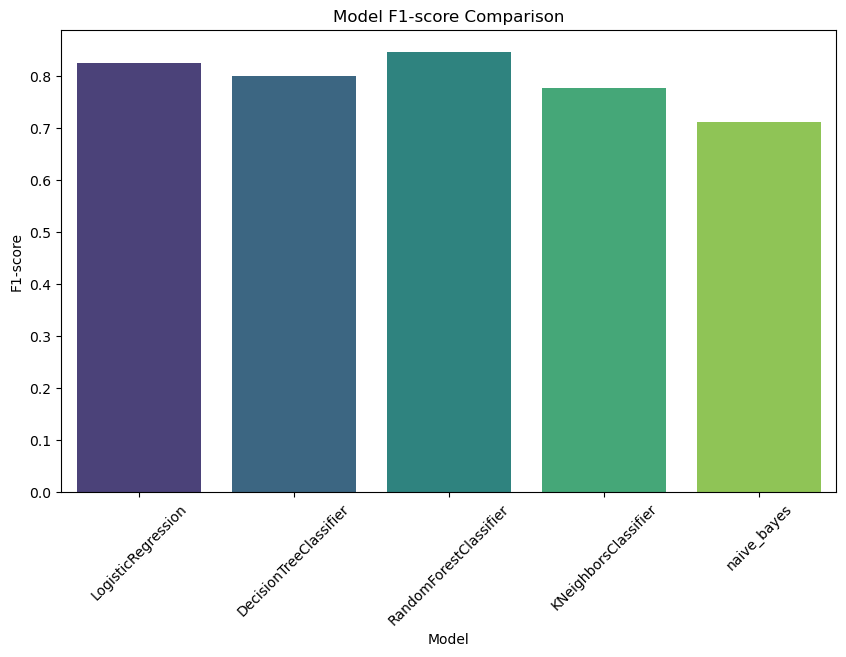

In [72]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Test F1', data=results_df, palette='viridis')
plt.title("Model F1-score Comparison")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.show()

"""
### Model Evaluation
Compute Accuracy, Precision, Recall, F1-score, and Confusion Matrix.

"""

KNN Evaluation Metrics:
Accuracy: 0.7854903716972682
Precision: 0.8018769551616267
Recall: 0.7268431001890359
F1-Score: 0.7625185919682697


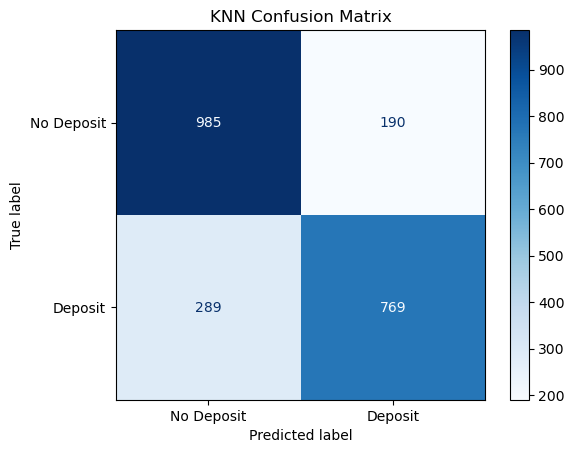

In [73]:

# Predictions (Tuned model)
y_pred = knn_grid.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("KNN Evaluation Metrics:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])
disp.plot(cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()


Naive Bayes Evaluation Metrics:
Accuracy: 0.7138378862516793
Precision: 0.7988587731811697
Recall: 0.5293005671077504
F1-Score: 0.6367254121660034


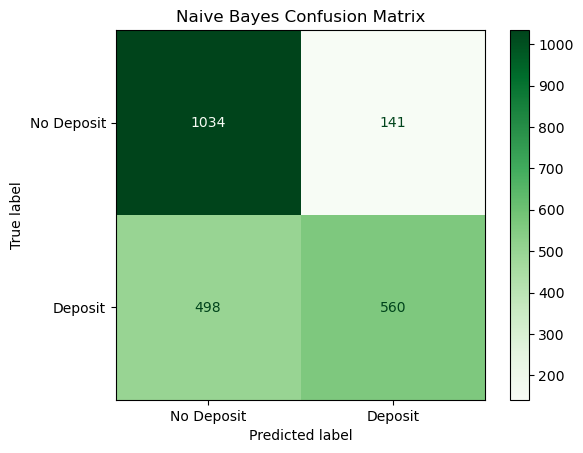

In [74]:
y_pred = nb_grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Naive Bayes Evaluation Metrics:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])
disp.plot(cmap='Greens')
plt.title("Naive Bayes Confusion Matrix")
plt.show()


Logistic Regression Evaluation Metrics:
Accuracy: 0.8298253470667264
Precision: 0.8210227272727273
Recall: 0.8194706994328923
F1-Score: 0.8202459791863765


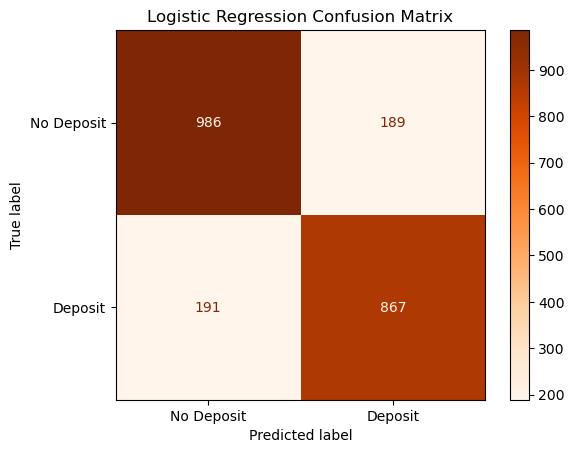

In [75]:
y_pred = lr_grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression Evaluation Metrics:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])
disp.plot(cmap='Oranges')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


Decision Tree Evaluation Metrics:
Accuracy: 0.8145991939095387
Precision: 0.8096153846153846
Recall: 0.7958412098298677
F1-Score: 0.8026692087702574


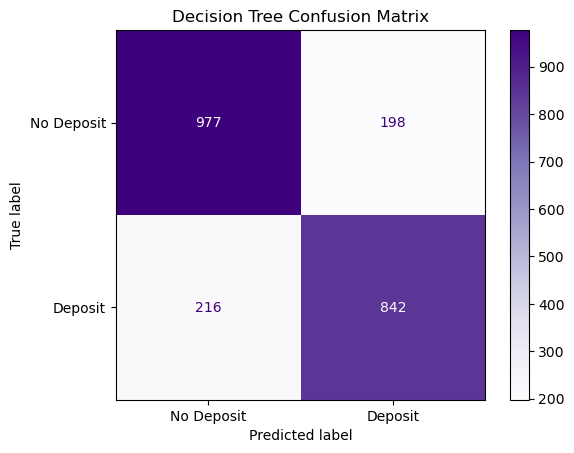

In [76]:
y_pred = dt_grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Decision Tree Evaluation Metrics:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])
disp.plot(cmap='Purples')
plt.title("Decision Tree Confusion Matrix")
plt.show()


Random Forest Evaluation Metrics:
Accuracy: 0.8571428571428571
Precision: 0.8215839860748477
Recall: 0.8922495274102079
F1-Score: 0.8554599003171727


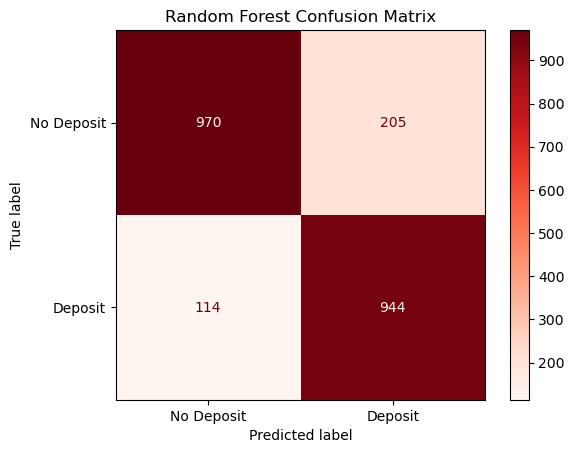

In [77]:
y_pred = rf_grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Random Forest Evaluation Metrics:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deposit', 'Deposit'])
disp.plot(cmap='Reds')
plt.title("Random Forest Confusion Matrix")
plt.show()


### Conclusion
-Random Forest achieved the highest performance
  It gave the best accuracy among all models, showing strong generalization and the ability to capture non-linear relationships in the data.

-Decision Tree performed very well but slightly below Random Forest
  It is simpler and easier to interpret than Random Forest, and still delivered competitive accuracy.

-KNN achieved good overall accuracy
  It performed reasonably well (around 0.81), but it can become slower and less scalable on larger datasets.

-Logistic Regression showed stable and reliable performance
  It achieved accuracy close to KNN, making it a good interpretable baseline model.

-Naive Bayes had the lowest accuracy
  It is extremely fast but assumes feature independence, which likely doesn't hold in your dataset—leading to reduced accuracy.

-Scaling and balancing (StandardScaler + SMOTE) improved model performance
  Especially for models sensitive to scale such as KNN and Logistic Regression.

In [78]:
# ...existing code...
# Export only the best tuned model (no retraining). Use X_test (scaled) instead of undefined X_te_scaled.
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report

# collect tuned estimators
grids = {}
for name in ('knn_grid','nb_grid','lr_grid','dt_grid','rf_grid'):
    if name in globals() and hasattr(globals()[name], "best_estimator_"):
        grids[name] = globals()[name].best_estimator_

if not grids:
    raise RuntimeError("No tuned GridSearchCV objects found (knn_grid, nb_grid, lr_grid, dt_grid, rf_grid)")

scores = {}
for name, est in grids.items():
    y_pred = est.predict(X_test)   # X_test is the test set already scaled earlier
    scores[name] = {
        'f1': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred, output_dict=True),
        'estimator': est
    }

best_name = max(scores, key=lambda k: scores[k]['f1'])
best_model = scores[best_name]['estimator']
print(f"Best model: {best_name}  —  F1: {scores[best_name]['f1']:.4f}  Acc: {scores[best_name]['accuracy']:.4f}")

# Save a clean target encoder fitted on y
target_le = LabelEncoder().fit(y)

bundle = {
    'model': best_model,
    'scaler': scaler,
    'features': list(X.columns),
    'target_le': target_le,
    'metrics': {best_name: scores[best_name]['report']}
}
joblib.dump(bundle, 'best_model_bundle.joblib')
print("Saved best_model_bundle.joblib")
# ...existing code...

Best model: rf_grid  —  F1: 0.8555  Acc: 0.8571
Saved best_model_bundle.joblib
